In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
#Simple likelihood complex posterior

class prior:
    def __init__(self):
        self.prior_theta = torch.distributions.Uniform(torch.tensor([-3.]).repeat(5),torch.tensor([3.]).repeat(5))
    def sample(self,shape):
        return self.prior_theta.sample(shape)
    def log_prob(self,theta):
        return torch.sum(self.prior_theta.log_prob(theta), dim = -1)

def simulate(theta):
    mean = theta[:, :2]
    cov = torch.zeros(theta.shape[0],2,2)
    s1 = torch.square(theta[:,2])
    s2 = torch.square(theta[:,3])
    rho = torch.tanh(theta[:,4])
    cov[:, 0,0] = torch.square(s1)
    cov[:,1,1] = torch.square(s2)
    cov[:,0,1], cov[:,1,0] = s1*s2*rho, s1*s2*rho
    return torch.distributions.MultivariateNormal(mean, (cov+torch.transpose(cov, dim0 = 1, dim1=2))/2).sample()

def posterior_log_prob(theta,x0):
    prior_log_prob = prior_theta.log_prob(theta)
    mean = theta[:, :2]
    cov = torch.zeros(theta.shape[0],2,2)
    s1 = torch.square(theta[:,2])
    s2 = torch.square(theta[:,3])
    rho = torch.tanh(theta[:,4])
    cov[:, 0,0] = torch.square(s1)
    cov[:,1,1] = torch.square(s2)
    cov[:,0,1], cov[:,1,0] = s1*s2*rho, s1*s2*rho
    log_likelihood = torch.sum(torch.distributions.MultivariateNormal(mean.unsqueeze(1).repeat(1,x0.shape[0],1),((cov+torch.transpose(cov, dim0 = 1, dim1=2))/2).unsqueeze(1).repeat(1,x0.shape[0],1,1)).log_prob(x0), dim = -1)
    return prior_log_prob + log_likelihood


prior_theta = prior()
theta_samples = prior_theta.sample([100])
x_samples = simulate(theta_samples)


theta0 = prior_theta.sample([1])
print(theta0)
n_x0 =1000
x0 = simulate(theta0.repeat(n_x0,1))

tensor([[ 0.4857, -0.6755,  1.7002,  0.1020, -0.9688]])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:27<00:00,  5.70it/s, acceptance = tensor(0.)]


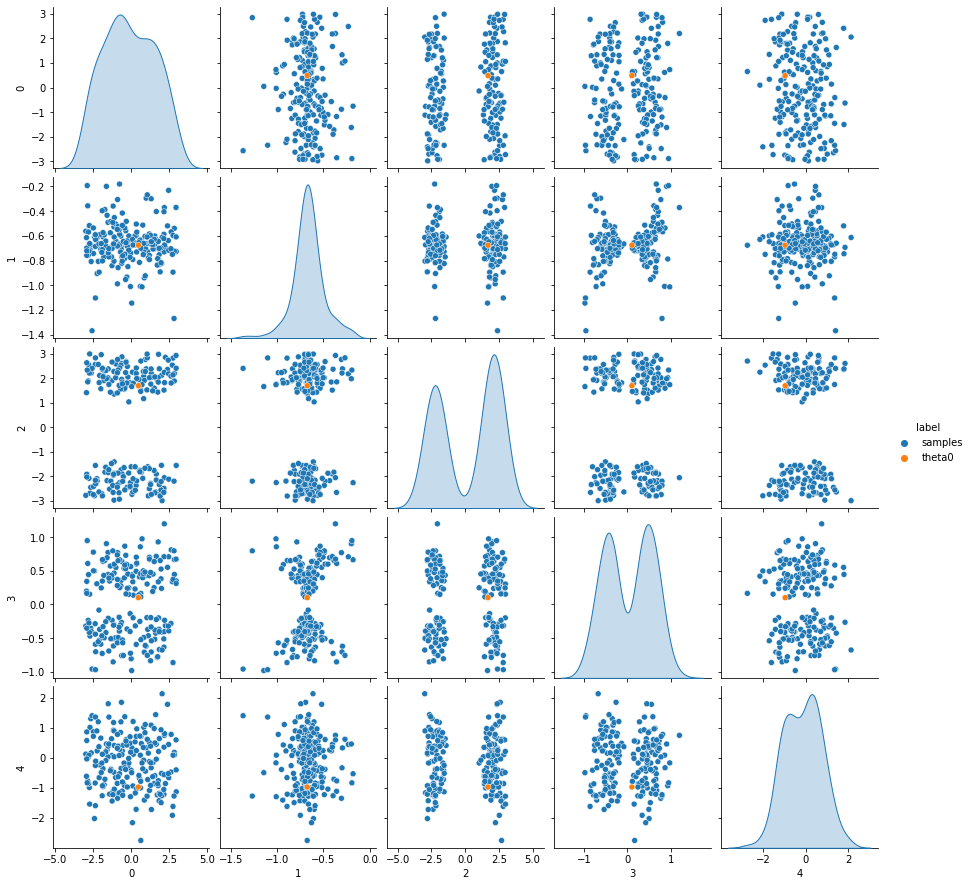

In [6]:
from samplers import IMH, ULA, HMC,MALA

sampler = IMH(lambda samples:posterior_log_prob(samples,x0),5,prior_theta,200)
posterior_samples = sampler.sample(500)

df_samples= pd.DataFrame(posterior_samples)
df_samples['label']= 'samples'
df_theta0 = pd.DataFrame(theta0)
df_theta0['label'] = 'theta0'
df= pd.concat([df_samples, df_theta0])
sns.pairplot(pd.DataFrame(df), hue = 'label')

In [7]:
from conditional_density_estimators import ConditionalDIFDensityEstimator
dif = ConditionalDIFDensityEstimator(x_samples, theta_samples,5,[64,64])
dif.train(500,1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.07it/s, loss = 0.948198 ; device: cuda]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:59<00:00,  1.32s/it, acceptance = tensor(0.)]


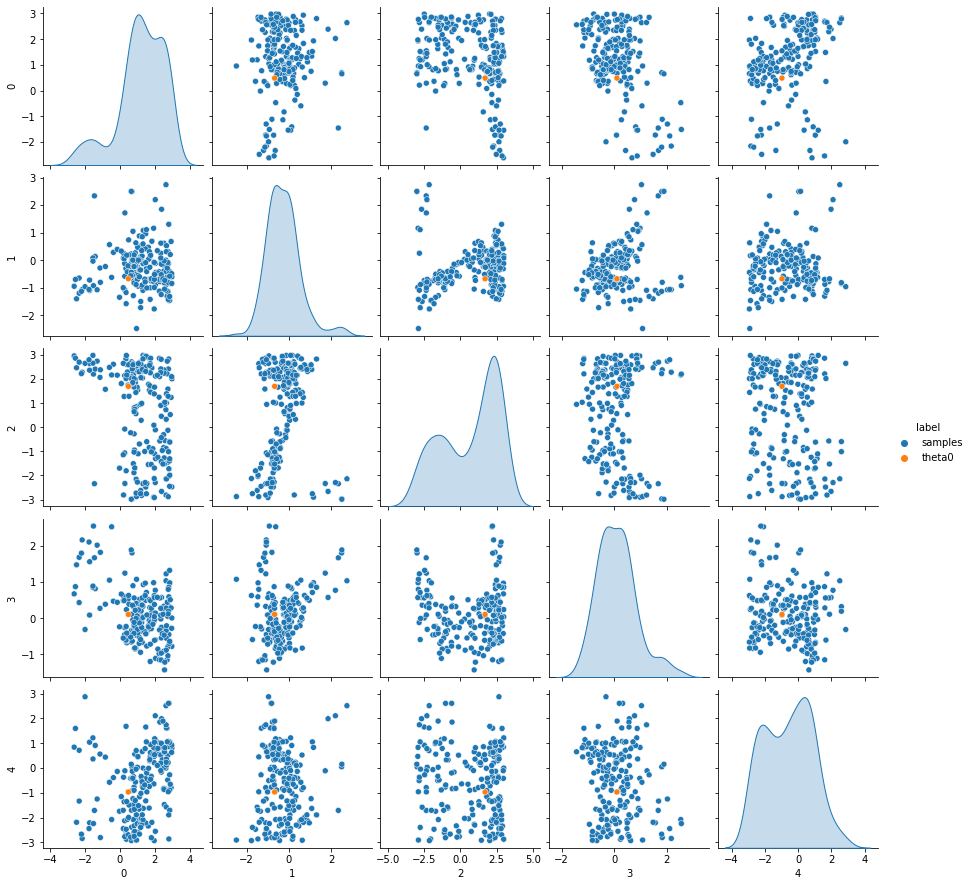

In [8]:
from samplers import IMH
x0_ = x0+10*torch.randn_like(x0)
def dif_posterior_log_prob(theta,x0):
    prior_log_prob = prior_theta.log_prob(theta)
    log_likelihood = torch.sum(dif.log_density(x0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, x0.shape[0],1)), dim=1)
    return prior_log_prob + log_likelihood
    
sampler = IMH(lambda samples:dif_posterior_log_prob(samples,x0),5,prior_theta,200)
samples = sampler.sample(500)

df_samples= pd.DataFrame(samples)
df_samples['label']= 'samples'
df_theta0 = pd.DataFrame(theta0)
df_theta0['label'] = 'theta0'
df= pd.concat([df_samples, df_theta0])
sns.pairplot(pd.DataFrame(df), hue = 'label')

In [35]:
hpd, x,y, modes = hpd_grid(posterior_samples)

TypeError: _amin_dispatcher() got an unexpected keyword argument 'dim'

In [33]:
print(hpd)

[(-2.93, 1.37), (1.81, 2.84)]


In [36]:
from __future__ import division
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
import scipy.stats.kde as kde

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes


def plot_post(sample, alpha=0.05, show_mode=True, kde_plot=True, bins=50, 
    ROPE=None, comp_val=None, roundto=2):
    """Plot posterior and HPD
    Parameters
    ----------
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    show_mode: Bool
        If True the legend will show the mode(s) value(s), if false the mean(s)
        will be displayed
    kde_plot: Bool
        If True the posterior will be displayed using a Kernel Density Estimation
        otherwise an histogram will be used
    bins: integer
        Number of bins used for the histogram, only works when kde_plot is False
    ROPE: list or numpy array
        Lower and upper values of the Region Of Practical Equivalence
    comp_val: float
        Comparison value
        
    Returns
    -------
    post_summary : dictionary
        Containing values with several summary statistics
    """       

    post_summary = {'mean':0,'median':0,'mode':0, 'alpha':0,'hpd_low':0,
                   'hpd_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}

    post_summary['mean'] = round(np.mean(sample), roundto)
    post_summary['median'] = round(np.median(sample), roundto)
    post_summary['alpha'] = alpha

    # Compute the hpd, KDE and mode for the posterior
    hpd, x, y, modes = hpd_grid(sample, alpha, roundto)
    post_summary['hpd'] = hpd
    post_summary['mode'] = modes

    ## Plot KDE.
    if kde_plot:
            plt.plot(x, y, color='k', lw=2)
    ## Plot histogram.
    else:
        plt.hist(sample, normed=True, bins=bins, facecolor='b', 
        edgecolor='w')

    ## Display mode or mean:
    if show_mode:
        string = '{:g} ' * len(post_summary['mode'])
        plt.plot(0, label='mode =' + string.format(*post_summary['mode']), alpha=0)
    else:
        plt.plot(0, label='mean = {:g}'.format(post_summary['mean']), alpha=0)

    ## Display the hpd.
    hpd_label = ''
    for value in hpd:
        plt.plot(value, [0, 0], linewidth=10, color='b')
        hpd_label = hpd_label +  '{:g} {:g}\n'.format(round(value[0], roundto), round(value[1], roundto)) 
    plt.plot(0, 0, linewidth=4, color='b', label='hpd {:g}%\n{}'.format((1-alpha)*100, hpd_label))
    ## Display the ROPE.
    if ROPE is not None:
        pc_in_ROPE = round(np.sum((sample > ROPE[0]) & (sample < ROPE[1]))/len(sample)*100, roundto)
        plt.plot(ROPE, [0, 0], linewidth=20, color='r', alpha=0.75)
        plt.plot(0, 0, linewidth=4, color='r', label='{:g}% in ROPE'.format(pc_in_ROPE))
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
    ## Display the comparison value.
    if comp_val is not None:
        pc_gt_comp_val = round(100 * np.sum(sample > comp_val)/len(sample), roundto)
        pc_lt_comp_val = round(100 - pc_gt_comp_val, roundto)
        plt.axvline(comp_val, ymax=.75, color='g', linewidth=4, alpha=0.75,
            label='{:g}% < {:g} < {:g}%'.format(pc_lt_comp_val, 
                                                comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val

    plt.legend(loc=0, framealpha=1)
    frame = plt.gca()
    frame.axes.get_yaxis().set_ticks([])
    return post_summary

C:\Users\Elouan\AppData\Local\Temp\ipykernel_1760\3536436202.py:33: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


{'mean': -0.11,
 'median': 0.11,
 'mode': [-2.43, 0.25],
 'alpha': 0.05,
 'hpd_low': 0,
 'hpd_high': 0,
 'comp_val': 0,
 'pc_gt_comp_val': 0,
 'ROPE_low': 0,
 'ROPE_high': 0,
 'pc_in_ROPE': 0,
 'hpd': [(-3.0, -1.24), (-0.86, 2.83)]}

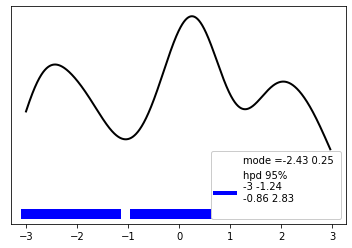

In [43]:
plot_post(posterior_samples.numpy())

In [ ]:
def hpd